# Baseline — Logistic Regression (Split Temporal)

Este notebook treina um baseline de classificação direcional (alta/queda) usando Logistic Regression.

Regras importantes:
- Split temporal (sem embaralhar)
- Não usar colunas de vazamento: `future_ret_w`, `future_ret_m`
- Avaliar com AUC/F1 (não só accuracy)


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix
)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

PARQUET_PATH = "../data/processed/ibov_top40_features.parquet"
CSV_PATH = "../data/processed/ibov_top40_features.csv"

def load_dataset():
    if os.path.exists(PARQUET_PATH):
        df_ = pd.read_parquet(PARQUET_PATH)
        source_ = PARQUET_PATH
    elif os.path.exists(CSV_PATH):
        df_ = pd.read_csv(CSV_PATH)
        source_ = CSV_PATH
    else:
        raise FileNotFoundError("Arquivo processado não encontrado. Rode: python -m src.features")
    return df_, source_

df, source = load_dataset()
print("Fonte:", source)
print("Shape:", df.shape)

# garantir datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date", "ticker"]).copy()

df.head()


Fonte: ../data/processed/ibov_top40_features.parquet
Shape: (83000, 38)


,date,ticker,open,high,low,close,volume,adjustedClose,adj_close,ret_1d,logret_1d,mom_5d,mom_21d,mom_63d,mom_126d,mom_252d,ma_10,price_to_ma_10,ma_21,price_to_ma_21,ma_63,price_to_ma_63,ma_126,price_to_ma_126,ma_252,price_to_ma_252,vol_10,vol_21,vol_63,logvol,logvol_z_63,hl_range,oc_change,rsi_14,future_ret_w,target_w,future_ret_m,target_m
0,2016-03-23,ABEV3,18.64,19.09,18.60,19.00,19093200,12.72,12.72,0.013546,0.013455,0.038367,0.040065,NaN,NaN,NaN,12.395,0.026220,12.343333,0.030516,NaN,NaN,NaN,NaN,NaN,NaN,0.014986,0.017234,NaN,16.764843,NaN,0.026344,0.019313,55.268818,-0.009434,0,0.007075,1
1,2016-03-23,BBAS3,9.99,9.99,9.75,9.82,19680000,3.03,3.03,-0.038095,-0.038840,0.086022,0.485294,NaN,NaN,NaN,3.146,-0.036872,2.772381,0.092923,NaN,NaN,NaN,NaN,NaN,NaN,0.098511,0.077428,NaN,16.795113,NaN,0.024615,-0.017017,53.392542,0.006601,1,0.059406,1
2,2016-03-23,BBDC3,14.56,14.67,14.10,14.29,3466917,8.63,8.63,-0.031425,-0.031930,0.107831,0.470187,NaN,NaN,NaN,8.496,0.015772,7.472381,0.154920,NaN,NaN,NaN,NaN,NaN,NaN,0.060574,0.045867,NaN,15.058776,NaN,0.040426,-0.018544,70.921669,-0.004635,0,-0.089224,0
3,2016-03-23,BBDC4,12.94,13.01,12.53,12.69,23897005,7.66,7.66,-0.032828,-0.033379,0.086525,0.421150,NaN,NaN,NaN,7.636,0.003143,6.815238,0.123952,NaN,NaN,NaN,NaN,NaN,NaN,0.061783,0.051653,NaN,16.989264,NaN,0.038308,-0.019320,64.715333,0.011749,1,-0.067885,0
4,2016-03-23,BBSE3,29.08,29.52,28.15,28.86,4138100,13.29,13.29,-0.009687,-0.009734,0.039093,0.152645,NaN,NaN,NaN,13.805,-0.037305,12.903333,0.029966,NaN,NaN,NaN,NaN,NaN,NaN,0.058347,0.046827,NaN,15.235747,NaN,0.048668,-0.007565,37.466094,0.029345,1,0.082769,1


In [ ]:
# Escolha do target: "target_w" (semanal) ou "target_m" (mensal)
TARGET = "target_m"

# Remover colunas de vazamento (não podem entrar como feature)
leak_cols = [c for c in df.columns if c.startswith("future_ret_")]
print("Removendo colunas de vazamento:", leak_cols)
df = df.drop(columns=leak_cols, errors="ignore")

# Remover linhas sem target
df = df.dropna(subset=[TARGET]).copy()
df[TARGET] = df[TARGET].astype(int)

print("Após remover NaN no target:", df.shape)
df[[ "date", "ticker", TARGET ]].head()


Removendo colunas de vazamento: ['future_ret_w', 'future_ret_m']
Após remover NaN no target: (83000, 36)


,date,ticker,target_m
0,2016-03-23,ABEV3,1
1,2016-03-23,BBAS3,1
2,2016-03-23,BBDC3,0
3,2016-03-23,BBDC4,0
4,2016-03-23,BBSE3,1


In [ ]:
# Conjunto base de features (core)
core_features = [
    "ret_1d", "logret_1d",
    "mom_5d", "mom_21d", "mom_63d",
    "price_to_ma_10", "price_to_ma_21", "price_to_ma_63",
    "vol_10", "vol_21", "vol_63",
    "hl_range", "oc_change",
    "logvol_z_63",
    "rsi_14",
]

# Filtrar só as que existem (robusto)
features = [c for c in core_features if c in df.columns]
missing = [c for c in core_features if c not in df.columns]
print("Features usadas:", features)
print("Features faltando:", missing)

# Segurança: remover colunas não numéricas
X_all = df[features].copy()
y_all = df[TARGET].copy()

print("X shape:", X_all.shape, "y shape:", y_all.shape)


Features usadas: ['ret_1d', 'logret_1d', 'mom_5d', 'mom_21d', 'mom_63d', 'price_to_ma_10', 'price_to_ma_21', 'price_to_ma_63', 'vol_10', 'vol_21', 'vol_63', 'hl_range', 'oc_change', 'logvol_z_63', 'rsi_14']
Features faltando: []
X shape: (83000, 15) y shape: (83000,)


In [ ]:
# Split temporal por datas
# Ajuste se quiser. Aqui: 70% treino, 15% val, 15% teste (por tempo)

df = df.sort_values("date").reset_index(drop=True)

dates = df["date"].sort_values().unique()
n = len(dates)

train_end = dates[int(n * 0.70)]
val_end   = dates[int(n * 0.85)]

train_mask = df["date"] <= train_end
val_mask   = (df["date"] > train_end) & (df["date"] <= val_end)
test_mask  = df["date"] > val_end

print("Train até:", train_end)
print("Val até  :", val_end)
print("Test de  :", dates[int(n*0.85)+1] if int(n*0.85)+1 < n else val_end)

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val, y_val     = X_all[val_mask],   y_all[val_mask]
X_test, y_test   = X_all[test_mask],  y_all[test_mask]

print("Sizes:")
print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

# baseline de classe majoritária no treino
maj = int(y_train.mode().iloc[0])
baseline_acc = (y_test == maj).mean()
print("Classe majoritária (treino):", maj)
print("Baseline accuracy (sempre majoritária no teste):", baseline_acc)


Train até: 2023-02-27 13:00:00
Val até  : 2024-08-19 13:00:00
Test de  : 2024-08-20 00:00:00
Sizes:
Train: (56103, 15) (56103,)
Val  : (13467, 15) (13467,)
Test : (13430, 15) (13430,)
Classe majoritária (treino): 1
Baseline accuracy (sempre majoritária no teste): 0.5197319434102755


In [ ]:
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        n_jobs=None,
        class_weight="balanced"
    ))
])

pipe.fit(X_train, y_train)

# Probabilidades
p_val = pipe.predict_proba(X_val)[:, 1]
p_test = pipe.predict_proba(X_test)[:, 1]

# Predições (threshold 0.5)
yhat_val = (p_val >= 0.5).astype(int)
yhat_test = (p_test >= 0.5).astype(int)

def metrics(name, y_true, yhat, p):
    auc = roc_auc_score(y_true, p)
    acc = accuracy_score(y_true, yhat)
    f1  = f1_score(y_true, yhat)
    print(f"\n== {name} ==")
    print("AUC:", auc)
    print("ACC:", acc)
    print("F1 :", f1)

metrics("VAL", y_val, yhat_val, p_val)
metrics("TEST", y_test, yhat_test, p_test)

print("\nClassification report (TEST):")
print(classification_report(y_test, yhat_test))

print("Confusion matrix (TEST):")
print(confusion_matrix(y_test, yhat_test))



== VAL ==
AUC: 0.5313092683044685
ACC: 0.4969183931090815
F1 : 0.48080312667637365

== TEST ==
AUC: 0.5112138113324893
ACC: 0.504765450483991
F1 : 0.4306138173101618

Classification report (TEST):
              precision    recall  f1-score   support

           0       0.49      0.66      0.56      6450
           1       0.53      0.36      0.43      6980

    accuracy                           0.50     13430
   macro avg       0.51      0.51      0.50     13430
weighted avg       0.51      0.50      0.49     13430

Confusion matrix (TEST):
[[4264 2186]
 [4465 2515]]


price_to_ma_63   -0.142369
rsi_14            0.085374
hl_range          0.064319
logvol_z_63      -0.058617
mom_63d           0.047426
mom_5d           -0.045852
vol_21           -0.041366
logret_1d        -0.040128
vol_63            0.038821
price_to_ma_10    0.032545
ret_1d           -0.024787
vol_10            0.013292
oc_change         0.011574
price_to_ma_21   -0.008449
mom_21d          -0.007837
dtype: float64

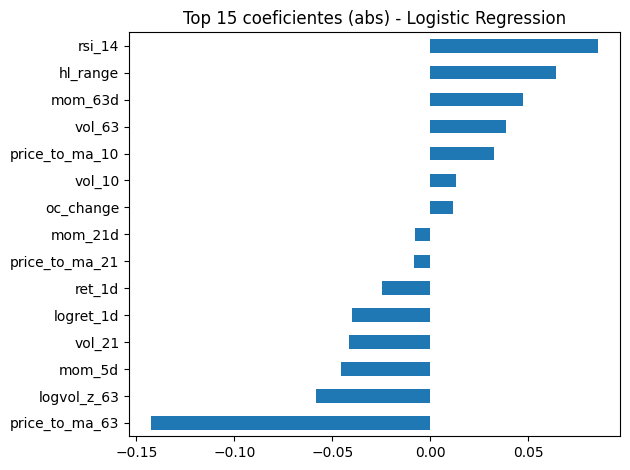

In [ ]:
# Coeficientes do modelo (após padronização)
clf = pipe.named_steps["clf"]
coef = pd.Series(clf.coef_[0], index=features).sort_values(key=lambda s: s.abs(), ascending=False)
display(coef)

plt.figure()
coef.head(15).sort_values().plot(kind="barh")
plt.title("Top 15 coeficientes (abs) - Logistic Regression")
plt.tight_layout()
plt.show()


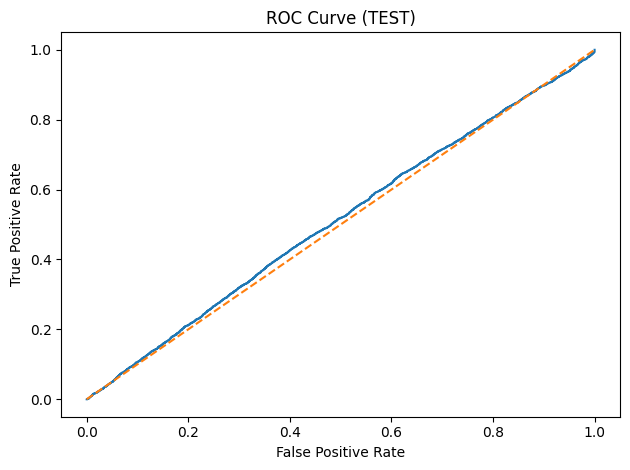

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_test, p_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve (TEST)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()


In [ ]:
# Avaliar performance média por ticker no TEST (simples)
test_df = df.loc[test_mask, ["date", "ticker"]].copy()
test_df["y"] = y_test.values
test_df["p"] = p_test
test_df["yhat"] = yhat_test

by_ticker = test_df.groupby("ticker").apply(
    lambda g: pd.Series({
        "n": len(g),
        "acc": (g["y"] == g["yhat"]).mean(),
        "auc": roc_auc_score(g["y"], g["p"]) if g["y"].nunique() > 1 else np.nan
    })
).sort_values("n", ascending=False)

display(by_ticker.head(15))
display(by_ticker.tail(15))


,n,acc,auc
ticker,,,
AXIA3,374.0,0.513369,0.551153
AXIA6,374.0,0.497326,0.547524
MBRF3,374.0,0.524064,0.564564
ALOS3,362.0,0.455801,0.373861
ABEV3,362.0,0.464088,0.450941
B3SA3,362.0,0.477901,0.452100
BBAS3,362.0,0.544199,0.531904
BBDC4,362.0,0.560773,0.597165
BBDC3,362.0,0.533149,0.534025


,n,acc,auc
ticker,,,
PETR4,362.0,0.494475,0.520708
PRIO3,362.0,0.461326,0.500278
RADL3,362.0,0.549724,0.558319
RAIL3,362.0,0.524862,0.550374
RDOR3,362.0,0.513812,0.556740
RENT3,362.0,0.513812,0.521521
SBSP3,362.0,0.477901,0.509824
SUZB3,362.0,0.511050,0.517397
TIMS3,362.0,0.464088,0.475925


## Avaliação Real


In [ ]:
# Recriar retorno futuro mensal (21 pregões) para backtest
H = 21  # horizonte mensal em pregões (igual ao features.py)

# Precisamos da base com date/ticker/adj_close no período de teste
df_bt = df[["date", "ticker", "adj_close"]].copy()
df_bt = df_bt.sort_values(["ticker", "date"]).reset_index(drop=True)

df_bt["future_ret_m"] = df_bt.groupby("ticker")["adj_close"].shift(-H) / df_bt["adj_close"] - 1

# (Opcional) também podemos criar o semanal:
# df_bt["future_ret_w"] = df_bt.groupby("ticker")["adj_close"].shift(-5) / df_bt["adj_close"] - 1

df_bt.head()


,date,ticker,adj_close,future_ret_m
0,2016-03-23,ABEV3,12.72,0.007075
1,2016-03-24,ABEV3,12.72,0.012579
2,2016-03-28,ABEV3,12.92,0.003096
3,2016-03-29,ABEV3,12.95,0.006178
4,2016-03-30,ABEV3,12.82,0.012480


In [ ]:
K = 10

# Precisamos mapear as probabilidades exatamente para as linhas do teste
# Vamos usar os índices do X_test (mesmo index do df filtrado)
test_idx = X_test.index

test_df = df.loc[test_idx, ["date", "ticker"]].copy()
test_df["proba"] = p_test

# Juntar com o retorno futuro mensal que recalculamos
test_df = test_df.merge(df_bt[["date", "ticker", "future_ret_m"]], on=["date", "ticker"], how="left")

# Remover linhas onde não dá pra calcular retorno futuro (últimos 21 dias de cada ticker)
test_df = test_df.dropna(subset=["future_ret_m"]).copy()

# Rebalanceamento mensal
test_df["year_month"] = test_df["date"].dt.to_period("M")

portfolio_returns = []
benchmark_returns = []
months = []

for ym, group in test_df.groupby("year_month"):
    ranked = group.sort_values("proba", ascending=False)

    top_k = ranked.head(K)

    port_ret = top_k["future_ret_m"].mean()
    bench_ret = group["future_ret_m"].mean()

    months.append(str(ym))
    portfolio_returns.append(port_ret)
    benchmark_returns.append(bench_ret)

portfolio_returns = pd.Series(portfolio_returns, index=months, name="TopK")
benchmark_returns = pd.Series(benchmark_returns, index=months, name="Benchmark")

print("Meses avaliados:", len(portfolio_returns))
portfolio_returns.head(), benchmark_returns.head()


Meses avaliados: 18


(2024-08   -0.024729
 2024-09   -0.018751
 2024-10   -0.065585
 2024-11   -0.056818
 2024-12    0.026196
 Name: TopK, dtype: float64,
 2024-08   -0.027831
 2024-09   -0.027571
 2024-10   -0.016773
 2024-11   -0.036761
 2024-12   -0.016659
 Name: Benchmark, dtype: float64)

=== Portfolio Top-K ===
{'Cumulative Return': 0.8688298781272259, 'Mean Monthly Return': 0.03695816917263577, 'Volatility': 0.05947837937081718, 'Sharpe (ann.)': 2.152493979791887, 'Max Drawdown': -0.1352022715496748, 'Months': 18}

=== Benchmark (Universe Mean) ===
{'Cumulative Return': 0.8000163887150302, 'Mean Monthly Return': 0.03519186050844067, 'Volatility': 0.06789155565438038, 'Sharpe (ann.)': 1.7956309831460804, 'Max Drawdown': -0.09437142636028228, 'Months': 18}


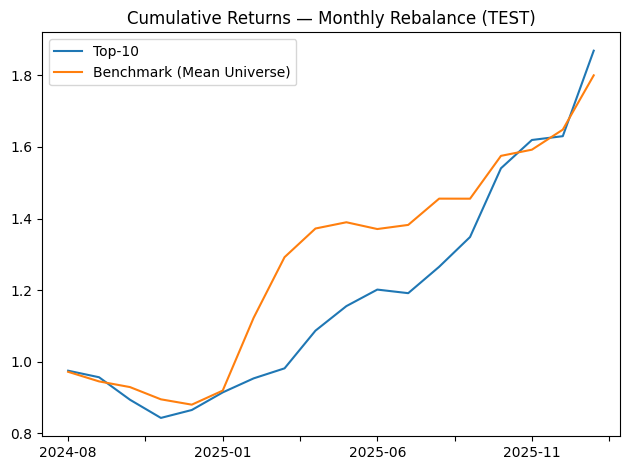

In [ ]:
def performance_stats(returns):
    equity = (1 + returns).cumprod()
    cum_return = equity.iloc[-1] - 1
    mean = returns.mean()
    vol = returns.std()
    sharpe = mean / vol * np.sqrt(12) if vol > 0 else np.nan
    drawdown = (equity / equity.cummax()) - 1
    max_dd = drawdown.min()
    return {
        "Cumulative Return": float(cum_return),
        "Mean Monthly Return": float(mean),
        "Volatility": float(vol),
        "Sharpe (ann.)": float(sharpe),
        "Max Drawdown": float(max_dd),
        "Months": int(len(returns)),
    }

print("=== Portfolio Top-K ===")
print(performance_stats(portfolio_returns))

print("\n=== Benchmark (Universe Mean) ===")
print(performance_stats(benchmark_returns))

plt.figure()
(1 + portfolio_returns).cumprod().plot(label=f"Top-{K}")
(1 + benchmark_returns).cumprod().plot(label="Benchmark (Mean Universe)")
plt.title("Cumulative Returns — Monthly Rebalance (TEST)")
plt.legend()
plt.tight_layout()
plt.show()


## 📊 Interpretação dos Resultados — Baseline (Logistic Regression)

### 1️⃣ Estrutura do experimento

- Dataset: 83.000 observações, 15 features técnicas.
- Target: `target_m` (direcional mensal).
- Split temporal:
  - Treino até 27/02/2023
  - Validação até 19/08/2024
  - Teste a partir de 20/08/2024
- Baseline de classe majoritária no teste: **~51.97%**

---

## 🎯 2️⃣ Performance Direcional

### Validação
- AUC: **0.531**
- Accuracy: 0.497
- F1: 0.481

### Teste (Out-of-Sample)
- AUC: **0.511**
- Accuracy: 0.505
- F1: 0.431

### Interpretação

- AUC ~0.51 no teste indica **poder discriminatório muito fraco**, próximo de aleatório.
- Accuracy ≈ 50% confirma que o modelo não supera claramente o baseline.
- A matriz de confusão mostra equilíbrio razoável entre classes (não colapsou para uma única classe).
- Portanto, como classificador puro, o modelo apresenta **edge estatístico muito pequeno**.

---

## 📈 3️⃣ Análise de Ranking (Top-K Mensal)

Avaliação no período de teste (18 meses):

### 🔹 Top-K Portfolio
- Cumulative Return: **+86.9%**
- Retorno médio mensal: 3.70%
- Volatilidade: 5.95%
- Sharpe anualizado: **2.15**
- Max Drawdown: -13.5%

### 🔹 Benchmark (média do universo)
- Cumulative Return: +80.0%
- Retorno médio mensal: 3.52%
- Volatilidade: 6.78%
- Sharpe: 1.80
- Max Drawdown: -9.4%

### Interpretação

- Apesar do fraco AUC, o ranking conseguiu gerar **leve outperformance**.
- A diferença de retorno médio mensal é pequena (~0.18% ao mês).
- O Sharpe elevado pode estar influenciado por:
  - Janela curta (18 meses)
  - Ambiente de mercado específico
- A performance não é suficientemente longa para conclusões estatísticas fortes.

---

## 🔎 4️⃣ Coeficientes do Modelo

Principais sinais aprendidos:

- `price_to_ma_63` (negativo forte)
- `rsi_14`
- `hl_range`
- `logvol_z_63`
- `mom_63d`

Isso indica que o modelo está capturando principalmente:
- Tendência relativa
- Momentum médio
- Compressão/extensão de preço
- Estrutura de volatilidade

---

## 🧠 Conclusão Geral do Baseline

- O pipeline está correto (sem vazamento aparente).
- O modelo linear apresenta **edge muito pequeno como classificador**.
- O ranking mostra sinal promissor, mas ainda **estatisticamente frágil**.
- A diferença em relação ao benchmark é modesta.

Este baseline cumpriu seu objetivo principal:
✔ Validar o pipeline  
✔ Medir sinal inicial  
✔ Estabelecer referência quantitativa  

---

## 🚀 Direções para a Versão Robusta (próximo notebook)

1. **Validação mais forte**
   - Walk-forward / rolling retraining
   - Intervalos de confiança para Sharpe
   - Sensibilidade a diferentes valores de K

2. **Métricas mais adequadas para finanças**
   - Information Coefficient (Spearman mensal)
   - Hit rate Top-K
   - Estratégia Long-Short (Top minus Bottom)

3. **Modelagem mais apropriada**
   - Regressão direta de `future_ret_m`
   - Modelos não-lineares (Gradient Boosting / XGBoost)
   - Normalização cross-sectional por data

4. **Backtest mais realista**
   - Custos de transação
   - Turnover
   - Controle de exposição

---

📌 Em resumo:

O baseline mostra que o sinal existe, mas é fraco e precisa de validação mais rigorosa.  
A próxima etapa deve focar em robustez estatística e modelagem mais adequada ao problema de ranking de retornos.
